In [1]:
!pip install tensorflow_text  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
import numpy as np
import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
use_builtins = True

In [4]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [5]:
import pandas as pd
data=pd.read_csv("/kaggle/input/dataset-hinge/dataset-hinge.csv")
data=data.dropna()
data['target_hinglish']=data['target_hinglish'].apply(lambda x: x.strip().replace('\n',''))
data['parallel_english']=data['parallel_english'].apply(lambda x: x.strip().replace('\n',''))
data['len_sen']=data['target_hinglish'].apply(lambda x: len(str(x).split(' ')))
data=data[data['len_sen']<=20]

In [6]:
data

,parallel_english,target_hinglish,len_sen
2,"and, when reminded, do not remember","aur jab unhen yad dilaya jata hai , to ve yad ...",14
3,you won the TED Prize 2011.,tumhen २०११ ka ted prize mil gaya hai,8
6,Really move all photos and videos to the trash?,kya aap vakee raddi men sare photos and videos...,12
7,Excavations made in Malabar have proved the ex...,malabar men khudaee ke kamron men rakhe hue ba...,17
8,And leave them desolate waste.,aur dharti ko ek samatal desolate maidan banak...,9
...,...,...,...
2755,Apply Rajiv Gandhi Advocate’s Training Scheme,rajiv gandhi advocate training hetu karna,7
2756,VIP s shild issue passes for gallery.,vishisht gallery passes for gallery jari karen.,7
2757,Ne _ ver Add Such File,such aesi file mat ne _ ver,8
2759,The meeting was held that very night at about ...,ratke lagabhag night ya 12 bajen yah meeting h...,9


In [7]:
inp=list(data["target_hinglish"])
targ=list(data['parallel_english'])

In [8]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'truth bat solah aane sahi hai .   gospel  \xc4\x8depek ne utsahpoorvak hami bhari .'
 b'kisi common goal ke lie milakar kam karna'
 b'aap abhi WiMAX network se kanekted hain'
 b'vah place jahan aap ek computer ko staring rahe hain jabki vah computer bahut slowly kuchh prosesing kar raha hai.'
 b'i  i matters vyakti hoon n , mujhe bekar ki baton se koee consequence nahin.'], shape=(5,), dtype=string)

tf.Tensor(
[b"\xe2\x80\x9c That ' s the gospel truth , \xe2\x80\x9d \xc4\x8cepek enthusiastically agreed ."
 b'working together for a common goal'
 b'You are now connected to the WiMAX network.'
 b'The place you go while you are staring at a computer that is processing something very slowly.'
 b'I am concerned with matters of consequence.'], shape=(5,), dtype=string)


In [10]:
example_text = tf.constant('Yahi haal hai')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Yahi haal hai'
b'Yahi haal hai'


In [11]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Yahi haal hai
[START] yahi haal hai [END]


In [13]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(    # handles vocabulary extraction & conversion of i/p text to sequences of tokens
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [14]:
input_text_processor.adapt(inp)    # initializes the layer based on the data

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]
# Hinglish TextVectorization layer

['', '[UNK]', '[START]', '[END]', '.', 'ke', 'hai', 'men', 'ki', ',']

In [15]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]
# English TextVectorization layer

['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'of', 'to', 'and']

In [16]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,  290,  114, 1488,  455,  328,    6,    4, 4524,    1],
       [   2,   68,  564, 2199,    5,   16,  518,  119,   55,    3],
       [   2,   34,  854, 1285, 1035,   13, 4235,   15,    3,    0]])>

In [17]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] truth bat solah aane sahi hai . gospel [UNK] ne utsahpoorvak hami bhari . [END]       '

Text(0.5, 1.0, 'Mask')

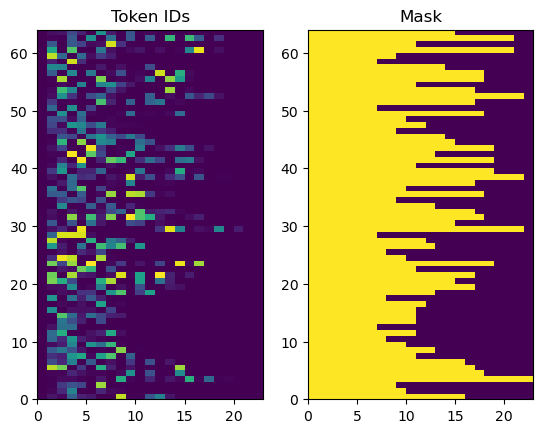

In [18]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [19]:
embedding_dim = 256
units = 1024

In [20]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [21]:
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 23)
Encoder output, shape (batch, s, units): (64, 23, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(units)

In [24]:
(example_tokens != 0).shape

TensorShape([64, 23])

In [25]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 23)


Text(0.5, 1.0, 'Mask')

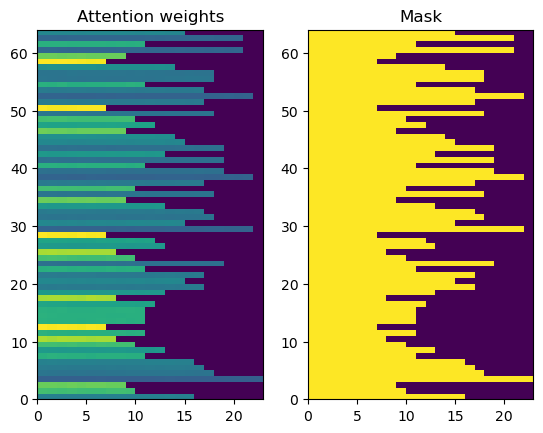

In [26]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


In [27]:
attention_weights.shape

TensorShape([64, 2, 23])

In [28]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 640x480 with 0 Axes>

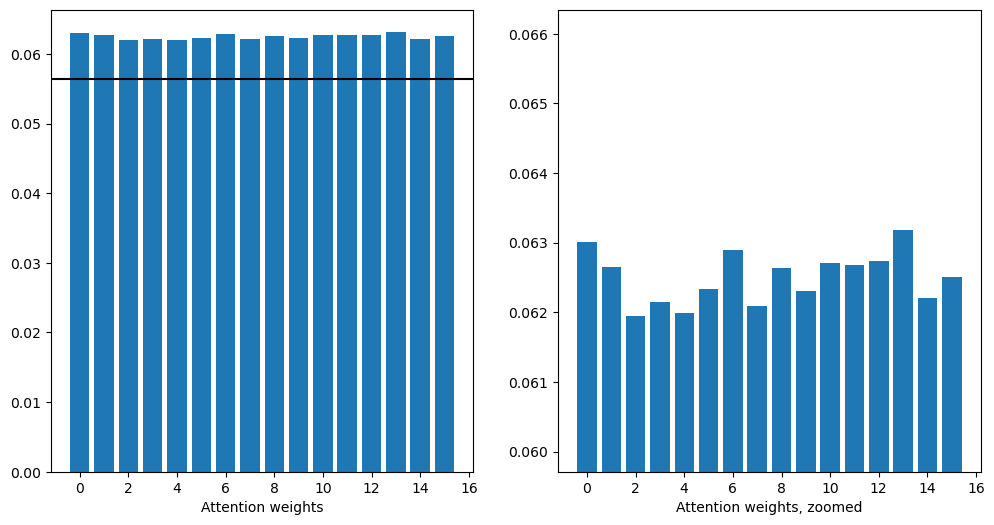

In [29]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [30]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [31]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [32]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [33]:
Decoder.call = call

In [34]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [35]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [36]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 4029)
state shape: (batch_size, dec_units) (64, 1024)


In [37]:
# sample token according to logits
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [38]:
# decode the token as first word of o/p
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['obama'],
       ['congress'],
       ['storage'],
       ['derivative'],
       ['islami']], dtype='<U27')

In [39]:
# decoder generates second set of logits
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [40]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['debunked'],
       ['contact'],
       ['authority'],
       ['channel'],
       ['bylaws']], dtype='<U27')

In [41]:
# Loss function definition
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [42]:
# implementing training step
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [43]:
# Receiving batches of english & hinglish data
# Converting those raw text inputs to token-embeddings and masks.
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [44]:
TrainTranslator._preprocess = _preprocess

In [45]:
# training
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [46]:
TrainTranslator._train_step = _train_step

In [47]:
# executes the decoder and calculates the incremental loss and new decoder state 
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [48]:
TrainTranslator._loop_step = _loop_step

In [49]:
# testing the training step
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [50]:
np.log(output_text_processor.vocabulary_size())

8.301273485191347

In [51]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.7080717>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6862693>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6470547>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.535873>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.0974965>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.599832>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.3761797>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2087784>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.996966>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9074917>}

CPU times: user 30.3 s, sys: 1.79 s, total: 32.1 s
Wall time: 29.9 s


In [52]:
# maximizing performance while training
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [53]:
TrainTranslator._tf_train_step = _tf_train_step

In [54]:
translator.use_tf_function = True

In [55]:
translator.train_step([example_input_batch, example_target_batch])

2023-03-08 11:11:41.546543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_526/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_526/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2023-03-08 11:11:41.671231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25
2023-03-08 11:11:41.782506: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export} failed: INVALID_ARGUMENT: Result #25 of node 'while/body/_1/while/decoder_1/gru_3/PartitionedCall' is out of bounds
	when importing GraphDef to MLIR module in 

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8867707>}

In [56]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8638706>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8133445>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7427645>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7017674>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.604427>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.542692>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.495299>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.463528>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.455058>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3764076>}

CPU times: user 7.03 s, sys: 731 ms, total: 7.76 s
Wall time: 4.67 s


....................................................................................................


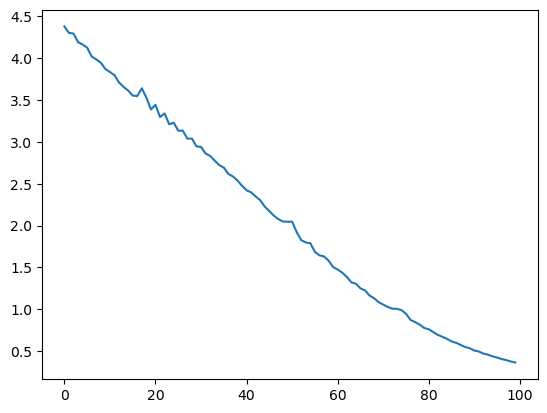

In [57]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [58]:
# building a fresh copy of the model to train from scratch since the training step is working
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [59]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [60]:
train_translator.fit(dataset, epochs=140,
                     callbacks=[batch_loss])

Epoch 1/140


2023-03-08 11:12:42.379241: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_582/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_582/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2023-03-08 11:12:42.511622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25
2023-03-08 11:12:42.633469: E tensorflow/core/grappler/optimizers/tfg_optimizer_hook.cc:134] tfg_optimizer{tfg-consolidate-attrs,tfg-toposort,tfg-shape-inference{graph-version=0},tfg-prepare-attrs-export} failed: INVALID_ARGUMENT: Result #25 of node 'StatefulPartitionedCall/while/body/_57/while/decoder_2/gru_5/Part

31/31 [==============================] - 26s 599ms/step - batch_loss: 6.2238
Epoch 2/140
31/31 [==============================] - 17s 544ms/step - batch_loss: 5.4531
Epoch 3/140
31/31 [==============================] - 17s 553ms/step - batch_loss: 5.1503
Epoch 4/140
31/31 [==============================] - 16s 510ms/step - batch_loss: 4.8011
Epoch 5/140
31/31 [==============================] - 17s 550ms/step - batch_loss: 4.4680
Epoch 6/140
31/31 [==============================] - 15s 497ms/step - batch_loss: 4.1309
Epoch 7/140
31/31 [==============================] - 16s 531ms/step - batch_loss: 3.6511
Epoch 8/140
31/31 [==============================] - 15s 480ms/step - batch_loss: 3.1151
Epoch 9/140
31/31 [==============================] - 15s 496ms/step - batch_loss: 2.6564
Epoch 10/140
31/31 [==============================] - 15s 473ms/step - batch_loss: 2.2793
Epoch 11/140
31/31 [==============================] - 15s 487ms/step - batch_loss: 1.9430
Epoch 12/140
31/31 [===========

In [61]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [62]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [63]:
# converting token IDs to human readable text
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [64]:
Translator.tokens_to_text = tokens_to_text

In [65]:
# inputting random token IDs to see what it generates
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'touches gift', b'alaukik embrace', b'cells since',
       b'histolytic minimum', b'hence distribute'], dtype=object)

In [66]:
# takes the decoder's logit outputs and samples token IDs from that distribution
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [67]:
Translator.sample = sample

In [68]:
# testing the function on random i/p
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1806],
       [1835],
       [3474],
       [ 507],
       [1862]])>

In [69]:
# implementing text to text translation loop
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [70]:
Translator.translate = translate_unrolled

In [73]:
# TESTING
input_text = tf.constant([
    'Waise really miss those days...', 
    'Yahi haal hai', 
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

commercial recovery of germanium has been read including book .
this apple tastes sour , doesn t it ?



In [74]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [75]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 21.9 s, sys: 386 ms, total: 22.3 s
Wall time: 22.2 s


In [76]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

ganga vally is the biggest in india
this is today adding this data there are

CPU times: user 156 ms, sys: 17.2 ms, total: 173 ms
Wall time: 129 ms


In [77]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [78]:
Translator.translate = translate_symbolic

In [80]:
# RUN THIS
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

saccus duty is scheduled on night shift .
this apple tastes sour , doesn t it ?



In [81]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [82]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.63 s, sys: 18.6 ms, total: 1.65 s
Wall time: 1.66 s


In [83]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

his duty is scheduled on night shift .
this apple tastes sour is doesn t it ?

CPU times: user 54.1 ms, sys: 5.53 ms, total: 59.6 ms
Wall time: 38.8 ms


In [84]:
%%time
three_input_text = tf.constant(['sabse best friend', 'That toh I know', 'She was bhunnoing the masalas jub phone ki ghuntee bugee',
])

result = translator.tf_translate(three_input_text)
print(result['text'])
for tr in result['text']:
  print(tr.numpy().decode())

print()

tf.Tensor(
[b'the main spring of dramatic feed feed may be followed compulsorily the war of the stove and the regulator .'
 b'it has been called chhath because of fast of suryashashthi .'
 b'the notion of csr is not new to india .'], shape=(3,), dtype=string)
the main spring of dramatic feed feed may be followed compulsorily the war of the stove and the regulator .
it has been called chhath because of fast of suryashashthi .
the notion of csr is not new to india .

CPU times: user 105 ms, sys: 8.1 ms, total: 114 ms
Wall time: 75.2 ms


In [85]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

In [86]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [87]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

the market is going to shri self up .
i had been a bit set here a new set .
the notion of csr is not new to india .

CPU times: user 66 ms, sys: 8.82 ms, total: 74.8 ms
Wall time: 49.4 ms
